In [1]:
from pathlib import Path
print("Notebook is running in:", Path.cwd())


Notebook is running in: C:\Users\Aren


In [3]:
import os
import requests
from pathlib import Path

# Create the download folder relative to your notebook
BASE_DIR = Path.cwd() / "DIV2K_raw"
BASE_DIR.mkdir(parents=True, exist_ok=True)

# List of URLs
urls = [
    "https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip",
    "https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip",
    "https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",
    "https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip"
]

# Download each file
for url in urls:
    filename = url.split("/")[-1]
    filepath = BASE_DIR / filename
    if filepath.exists():
        print(f"✅ Already downloaded: {filename}")
    else:
        print(f"⬇ Downloading {filename}...")
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(filepath, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"✅ Saved: {filename}")


✅ Already downloaded: DIV2K_train_HR.zip
✅ Already downloaded: DIV2K_train_LR_bicubic_X2.zip
✅ Already downloaded: DIV2K_valid_HR.zip
✅ Already downloaded: DIV2K_valid_LR_bicubic_X2.zip


In [4]:
import zipfile

for zip_path in BASE_DIR.glob("*.zip"):
    extract_to = BASE_DIR / zip_path.stem
    extract_to.mkdir(parents=True, exist_ok=True)
    print(f"📦 Extracting {zip_path.name} to {extract_to}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

print("✅ All ZIPs extracted.")


📦 Extracting DIV2K_train_HR.zip to C:\Users\Aren\DIV2K_raw\DIV2K_train_HR
📦 Extracting DIV2K_train_LR_bicubic_X2.zip to C:\Users\Aren\DIV2K_raw\DIV2K_train_LR_bicubic_X2
📦 Extracting DIV2K_valid_HR.zip to C:\Users\Aren\DIV2K_raw\DIV2K_valid_HR
📦 Extracting DIV2K_valid_LR_bicubic_X2.zip to C:\Users\Aren\DIV2K_raw\DIV2K_valid_LR_bicubic_X2
✅ All ZIPs extracted.


In [6]:
import shutil

# Move files from X2 subfolder to parent
src = BASE_DIR / "DIV2K_train_LR_bicubic_X2" / "DIV2K_train_LR_bicubic" / "X2"
dst = BASE_DIR / "DIV2K_train_LR_bicubic_X2"

for f in src.glob("*.png"):
    shutil.move(str(f), dst / f.name)

print(f"✅ Moved {len(list(dst.glob('*.png')))} LR images to {dst}")


✅ Moved 800 LR images to C:\Users\Aren\DIV2K_raw\DIV2K_train_LR_bicubic_X2


In [ ]:

from pathlib import Path

# === Local paths based on D:/SUPERCV structure ===
HR_DIR = Path("D:/SUPERCV/DIV2K_raw/DIV2K_train_HR/DIV2K_train_HR") #your path here
LR_DIR = Path("D:/SUPERCV/DIV2K_raw/DIV2K_train_LR_bicubic_X2") #your path here

hr_files = sorted(HR_DIR.glob("*.png"))
lr_files = sorted(LR_DIR.glob("*.png"))

# Simple matching by filename (already aligned)
matched_hr = hr_files
matched_lr = lr_files

print(f"✅ Matched {len(matched_hr)} HR/LR image pairs.")

✅ Matched 800 HR/LR image pairs.


In [8]:
hr_files = sorted(HR_DIR.glob("*.png"))
print("HR count:", len(hr_files))
print("First 5 HR files:", [f.name for f in hr_files[:5]])


HR count: 800
First 5 HR files: ['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [ ]:
import cv2
import numpy as np
import random
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# === Set base paths ===
BASE_DIR = Path("C:/Users/Aren/DIV2K_raw") #your path here
HR_DIR = BASE_DIR / "DIV2K_train_HR" / "DIV2K_train_HR"
LR_DIR = BASE_DIR / "DIV2K_train_LR_bicubic_X2"

# Output directories
OUT_HR_DIR = BASE_DIR / "Augmented_Data" / "AUG_DIV2K_train_HR"
OUT_LR_DIR = BASE_DIR / "Augmented_Data" / "AUG_DIV2K_train_LR_bicubic_X2"
VAL_HR_OUT = BASE_DIR / "Validation_Set" / "DIV2K_valid_HR"
VAL_LR_OUT = BASE_DIR / "Validation_Set" / "DIV2K_valid_LR_bicubic_X2"

for folder in [OUT_HR_DIR, OUT_LR_DIR, VAL_HR_OUT, VAL_LR_OUT]:
    folder.mkdir(parents=True, exist_ok=True)

# === Match HR and LR ===
hr_files = sorted(HR_DIR.glob("*.png"))
lr_files = sorted(LR_DIR.glob("*.png"))

def normalize_lr_name(file):
    return file.name.replace("x2.png", ".png")

hr_dict = {f.name: f for f in hr_files}
lr_dict = {normalize_lr_name(f): f for f in lr_files}
common_names = sorted(set(hr_dict.keys()) & set(lr_dict.keys()))

matched_hr = [hr_dict[name] for name in common_names]
matched_lr = [lr_dict[name] for name in common_names]

print(f"✅ Matched {len(matched_hr)} HR/LR image pairs.")

# === Split train/val ===
train_hr, val_hr, train_lr, val_lr = train_test_split(
    matched_hr, matched_lr, test_size=0.1, random_state=42
)

print(f"📁 Train: {len(train_hr)} pairs | Validation: {len(val_hr)} pairs")

# === Augmentation functions ===
def rotate_image(img): return cv2.rotate(img, random.choice([
    cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]))

def shear_image(img, factor):
    h, w = img.shape[:2]
    M = np.array([[1, factor, 0], [0, 1, 0]], dtype=np.float32)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def flip_image(img): return cv2.flip(img, 1)

def crop_image(img, crop_size):
    h, w = img.shape[:2]
    if h < crop_size or w < crop_size:
        return cv2.resize(img, (crop_size, crop_size))
    top = random.randint(0, h - crop_size)
    left = random.randint(0, w - crop_size)
    return img[top:top+crop_size, left:left+crop_size]

def add_gaussian_noise(img, mean=50, std=50, for_display=False):
    noise = np.random.normal(mean, std, img.shape)
    noisy_img = img + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    
    if for_display:
        # Convert to RGB if visualizing (e.g., matplotlib)
        return cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
    else:
        # Keep as BGR for saving with OpenCV
        return noisy_img


# === Apply augmentations ===
def augment_and_save(hr_path, lr_path):
    base = hr_path.stem
    hr = cv2.imread(str(hr_path))
    lr = cv2.imread(str(lr_path))
    if hr is None or lr is None:
        print(f"⚠️ Skipping {base}")
        return

    aug_funcs = [
        ("_1", rotate_image),
        ("_2", lambda img: shear_image(img, 0.2)),
        ("_3", lambda img: shear_image(img, -0.2)),
        ("_4", flip_image),
        ("_5", lambda img: crop_image(img, 512 if img.shape[0] > 256 else 128)),
        ("_6", add_gaussian_noise)
    ]

    for suffix, func in aug_funcs:
        hr_aug = func(hr)
        lr_aug = func(lr)
        cv2.imwrite(str(OUT_HR_DIR / f"{base}{suffix}.png"), hr_aug)
        cv2.imwrite(str(OUT_LR_DIR / f"{base}{suffix}.png"), lr_aug)

# === Augment train set ===
print("🔄 Augmenting training set...")
for hr, lr in tqdm(zip(train_hr, train_lr), total=len(train_hr)):
    augment_and_save(hr, lr)

# === Copy validation set ===
print("📋 Copying validation set...")
for hr, lr in zip(val_hr, val_lr):
    shutil.copy(hr, VAL_HR_OUT / hr.name)
    shutil.copy(lr, VAL_LR_OUT / lr.name)

print("✅ All done! Your data is augmented and ready.")

✅ Matched 800 HR/LR image pairs.
📁 Train: 720 pairs | Validation: 80 pairs
🔄 Augmenting training set...


100%|██████████| 720/720 [09:16<00:00,  1.29it/s]


📋 Copying validation set...
✅ All done! Your data is augmented and ready.


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt


In [19]:
class SRCNN(nn.Module):
    def __init__(self, upscale_factor=4):
        super(SRCNN, self).__init__()
        self.upscale = nn.Upsample(scale_factor=upscale_factor, mode='bicubic', align_corners=False)
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        x = self.upscale(x)
        return self.net(x)


In [21]:
class DIV2KSuperResDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, size=(128, 128), hr_size=(512, 512)):
        self.lr_files = sorted(Path(lr_dir).glob("*.png"))
        self.hr_files = sorted(Path(hr_dir).glob("*.png"))
        assert len(self.lr_files) == len(self.hr_files), "Mismatch in LR/HR count"

        self.lr_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor()
        ])
        self.hr_transform = transforms.Compose([
            transforms.Resize(hr_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.lr_files)

    def __getitem__(self, idx):
        lr_img = Image.open(self.lr_files[idx]).convert("RGB")
        hr_img = Image.open(self.hr_files[idx]).convert("RGB")
        return self.lr_transform(lr_img), self.hr_transform(hr_img)



In [23]:
def calculate_psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    if mse == 0:
        return 100
    return 10 * torch.log10(1 / mse)


In [53]:
import torch
import time
import json
import psutil
from tqdm import tqdm

def save_history_to_disk(history, filename="training_history.json"):
    with open(filename, "w") as f:
        json.dump(history, f)

def train_validate_safe(model, train_loader, val_loader, optimizer, scheduler, criterion, device, num_epochs=2, print_every=50, ckpt_path="best_model.pth"):
    best_psnr = 0
    history = {"train_loss": [], "val_psnr": []}

    for epoch in range(1, num_epochs + 1):
        print(f"\n📘 Epoch {epoch}/{num_epochs}")
        model.train()
        running_loss = 0
        epoch_start = time.time()

        for batch_idx, (lr_imgs, hr_imgs) in enumerate(tqdm(train_loader, desc="🔁 Training", leave=True)):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            optimizer.zero_grad()
            preds = model(lr_imgs)
            loss = criterion(preds, hr_imgs)

            # ✅ NaN or exploding loss protection
            if torch.isnan(loss):
                print("❌ NaN loss encountered — stopping early.")
                return history
            if loss.item() > 1e3:
                print(f"⚠️ Loss unusually high: {loss.item():.2f}")
                return history

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if print_every and (batch_idx + 1) % print_every == 0:
                print(f"[Epoch {epoch} | Batch {batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

            # ✅ Save checkpoint periodically
            if (batch_idx + 1) % 200 == 0:
                temp_ckpt = f"model_epoch{epoch}_batch{batch_idx}.pth"
                torch.save(model.state_dict(), temp_ckpt)
                print(f"💾 Checkpoint saved: {temp_ckpt}")

        avg_train_loss = running_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        # === Validation ===
        model.eval()
        total_psnr = 0
        with torch.no_grad():
            for lr_imgs, hr_imgs in tqdm(val_loader, desc="🧪 Validation", leave=True):
                lr_imgs = lr_imgs.to(device)
                hr_imgs = hr_imgs.to(device)
                preds = model(lr_imgs)

                mse = F.mse_loss(preds, hr_imgs)
                psnr = 10 * torch.log10(1 / mse)
                total_psnr += psnr.item()

        avg_psnr = total_psnr / len(val_loader)
        history["val_psnr"].append(avg_psnr)

        print(f"📈 Val PSNR: {avg_psnr:.2f} dB | Train Loss: {avg_train_loss:.4f} | ⏱ Epoch Time: {time.time() - epoch_start:.1f}s")

        if avg_psnr > best_psnr:
            best_psnr = avg_psnr
            torch.save(model.state_dict(), ckpt_path)
            print("💾 Saved new best model!")

        save_history_to_disk(history)
        scheduler.step()

        # ✅ Optional: system memory usage
        print(f"🧠 System Memory Used: {psutil.virtual_memory().percent}%")

    print("✅ Training complete.")
    return history


In [ ]:
from torch.utils.data import DataLoader
# Example: assuming you have a DIV2KSuperResDataset class

train_dataset = DIV2KSuperResDataset(
    lr_dir="C:/Users/Aren/DIV2K_raw/Augmented_Data/AUG_DIV2K_train_LR_bicubic_X2", #your path here
    hr_dir="C:/Users/Aren/DIV2K_raw/Augmented_Data/AUG_DIV2K_train_HR" #your path here
)

val_dataset = DIV2KSuperResDataset(
    lr_dir="C:/Users/Aren/DIV2K_raw/Validation_Set/DIV2K_valid_LR_bicubic_X2", #your path here
    hr_dir="C:/Users/Aren/DIV2K_raw/Validation_Set/DIV2K_valid_HR" #your path here
)

# Smaller batch size for stability
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


def combined_loss(preds, targets):
    l1 = F.l1_loss(preds, targets)
    mse = F.mse_loss(preds, targets)
    return 0.8 * l1 + 0.2 * mse


model = SRCNN(upscale_factor=4).to(device)
criterion = combined_loss
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print("Model is on:", next(model.parameters()).device)

# Run the safe training loop
history = train_validate_safe(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=device,
    num_epochs=40,
    print_every=50
)


Using device: cuda
Model is on: cuda:0

📘 Epoch 1/40


🔁 Training:  37%|███▋      | 50/135 [02:09<03:02,  2.15s/it]

[Epoch 1 | Batch 50/135] Loss: 0.1198


🔁 Training:  74%|███████▍  | 100/135 [03:59<01:17,  2.20s/it]

[Epoch 1 | Batch 100/135] Loss: 0.0827


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 21.65 dB | Train Loss: 0.1340 | ⏱ Epoch Time: 324.4s
💾 Saved new best model!
🧠 System Memory Used: 43.4%

📘 Epoch 2/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:05,  2.18s/it]

[Epoch 2 | Batch 50/135] Loss: 0.1056


🔁 Training:  74%|███████▍  | 100/135 [03:38<01:16,  2.17s/it]

[Epoch 2 | Batch 100/135] Loss: 0.0745


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


📈 Val PSNR: 22.60 dB | Train Loss: 0.0900 | ⏱ Epoch Time: 303.4s
💾 Saved new best model!
🧠 System Memory Used: 42.9%

📘 Epoch 3/40


🔁 Training:  37%|███▋      | 50/135 [01:50<03:08,  2.22s/it]

[Epoch 3 | Batch 50/135] Loss: 0.0937


🔁 Training:  74%|███████▍  | 100/135 [03:38<01:14,  2.12s/it]

[Epoch 3 | Batch 100/135] Loss: 0.0734


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


📈 Val PSNR: 23.01 dB | Train Loss: 0.0882 | ⏱ Epoch Time: 302.4s
💾 Saved new best model!
🧠 System Memory Used: 42.8%

📘 Epoch 4/40


🔁 Training:  37%|███▋      | 50/135 [01:49<03:05,  2.18s/it]

[Epoch 4 | Batch 50/135] Loss: 0.0857


🔁 Training:  74%|███████▍  | 100/135 [03:37<01:18,  2.24s/it]

[Epoch 4 | Batch 100/135] Loss: 0.0913


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 23.21 dB | Train Loss: 0.0875 | ⏱ Epoch Time: 303.5s
💾 Saved new best model!
🧠 System Memory Used: 42.6%

📘 Epoch 5/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:12,  2.26s/it]

[Epoch 5 | Batch 50/135] Loss: 0.0941


🔁 Training:  74%|███████▍  | 100/135 [03:37<01:16,  2.19s/it]

[Epoch 5 | Batch 100/135] Loss: 0.0906


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 23.39 dB | Train Loss: 0.0869 | ⏱ Epoch Time: 300.9s
💾 Saved new best model!
🧠 System Memory Used: 42.2%

📘 Epoch 6/40


🔁 Training:  37%|███▋      | 50/135 [01:46<03:01,  2.14s/it]

[Epoch 6 | Batch 50/135] Loss: 0.0811


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:15,  2.17s/it]

[Epoch 6 | Batch 100/135] Loss: 0.0711


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


📈 Val PSNR: 23.49 dB | Train Loss: 0.0864 | ⏱ Epoch Time: 300.3s
💾 Saved new best model!
🧠 System Memory Used: 42.5%

📘 Epoch 7/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:02,  2.14s/it]

[Epoch 7 | Batch 50/135] Loss: 0.0972


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:18,  2.24s/it]

[Epoch 7 | Batch 100/135] Loss: 0.0546


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 23.73 dB | Train Loss: 0.0861 | ⏱ Epoch Time: 300.1s
💾 Saved new best model!
🧠 System Memory Used: 42.0%

📘 Epoch 8/40


🔁 Training:  37%|███▋      | 50/135 [01:50<03:09,  2.23s/it]

[Epoch 8 | Batch 50/135] Loss: 0.0730


🔁 Training:  74%|███████▍  | 100/135 [03:40<01:17,  2.21s/it]

[Epoch 8 | Batch 100/135] Loss: 0.1009


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


📈 Val PSNR: 23.87 dB | Train Loss: 0.0858 | ⏱ Epoch Time: 302.7s
💾 Saved new best model!
🧠 System Memory Used: 41.8%

📘 Epoch 9/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:03,  2.16s/it]

[Epoch 9 | Batch 50/135] Loss: 0.1057


🔁 Training:  74%|███████▍  | 100/135 [03:37<01:18,  2.24s/it]

[Epoch 9 | Batch 100/135] Loss: 0.0592


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


📈 Val PSNR: 23.81 dB | Train Loss: 0.0857 | ⏱ Epoch Time: 299.9s
🧠 System Memory Used: 41.9%

📘 Epoch 10/40


🔁 Training:  37%|███▋      | 50/135 [01:47<03:06,  2.20s/it]

[Epoch 10 | Batch 50/135] Loss: 0.0918


🔁 Training:  74%|███████▍  | 100/135 [03:35<01:20,  2.30s/it]

[Epoch 10 | Batch 100/135] Loss: 0.0798


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


📈 Val PSNR: 23.93 dB | Train Loss: 0.0855 | ⏱ Epoch Time: 299.6s
💾 Saved new best model!
🧠 System Memory Used: 42.0%

📘 Epoch 11/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:06,  2.20s/it]

[Epoch 11 | Batch 50/135] Loss: 0.0721


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:15,  2.15s/it]

[Epoch 11 | Batch 100/135] Loss: 0.0914


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


📈 Val PSNR: 24.09 dB | Train Loss: 0.0852 | ⏱ Epoch Time: 300.5s
💾 Saved new best model!
🧠 System Memory Used: 41.9%

📘 Epoch 12/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:04,  2.17s/it]

[Epoch 12 | Batch 50/135] Loss: 0.0983


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:17,  2.21s/it]

[Epoch 12 | Batch 100/135] Loss: 0.0768


🧪 Validation: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


📈 Val PSNR: 24.11 dB | Train Loss: 0.0851 | ⏱ Epoch Time: 300.1s
💾 Saved new best model!
🧠 System Memory Used: 41.9%

📘 Epoch 13/40


🔁 Training:  37%|███▋      | 50/135 [01:49<03:16,  2.31s/it]

[Epoch 13 | Batch 50/135] Loss: 0.0950


🔁 Training:  74%|███████▍  | 100/135 [03:37<01:20,  2.30s/it]

[Epoch 13 | Batch 100/135] Loss: 0.0582


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


📈 Val PSNR: 24.16 dB | Train Loss: 0.0850 | ⏱ Epoch Time: 301.5s
💾 Saved new best model!
🧠 System Memory Used: 41.9%

📘 Epoch 14/40


🔁 Training:  37%|███▋      | 50/135 [01:49<03:02,  2.15s/it]

[Epoch 14 | Batch 50/135] Loss: 0.0850


🔁 Training:  74%|███████▍  | 100/135 [03:37<01:15,  2.15s/it]

[Epoch 14 | Batch 100/135] Loss: 0.1039


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


📈 Val PSNR: 24.19 dB | Train Loss: 0.0849 | ⏱ Epoch Time: 299.8s
💾 Saved new best model!
🧠 System Memory Used: 41.9%

📘 Epoch 15/40


🔁 Training:  37%|███▋      | 50/135 [01:46<02:58,  2.10s/it]

[Epoch 15 | Batch 50/135] Loss: 0.1052


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:17,  2.20s/it]

[Epoch 15 | Batch 100/135] Loss: 0.1035


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 24.22 dB | Train Loss: 0.0849 | ⏱ Epoch Time: 301.1s
💾 Saved new best model!
🧠 System Memory Used: 41.9%

📘 Epoch 16/40


🔁 Training:  37%|███▋      | 50/135 [01:46<03:00,  2.12s/it]

[Epoch 16 | Batch 50/135] Loss: 0.0992


🔁 Training:  74%|███████▍  | 100/135 [03:35<01:15,  2.15s/it]

[Epoch 16 | Batch 100/135] Loss: 0.1017


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


📈 Val PSNR: 24.24 dB | Train Loss: 0.0848 | ⏱ Epoch Time: 299.3s
💾 Saved new best model!
🧠 System Memory Used: 42.0%

📘 Epoch 17/40


🔁 Training:  37%|███▋      | 50/135 [01:47<03:04,  2.17s/it]

[Epoch 17 | Batch 50/135] Loss: 0.0504


🔁 Training:  74%|███████▍  | 100/135 [03:35<01:14,  2.13s/it]

[Epoch 17 | Batch 100/135] Loss: 0.0752


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


📈 Val PSNR: 24.24 dB | Train Loss: 0.0847 | ⏱ Epoch Time: 300.2s
🧠 System Memory Used: 41.9%

📘 Epoch 18/40


🔁 Training:  37%|███▋      | 50/135 [01:47<03:12,  2.27s/it]

[Epoch 18 | Batch 50/135] Loss: 0.0812


🔁 Training:  74%|███████▍  | 100/135 [03:35<01:15,  2.15s/it]

[Epoch 18 | Batch 100/135] Loss: 0.0842


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


📈 Val PSNR: 24.16 dB | Train Loss: 0.0848 | ⏱ Epoch Time: 298.9s
🧠 System Memory Used: 42.0%

📘 Epoch 19/40


🔁 Training:  37%|███▋      | 50/135 [01:49<03:03,  2.15s/it]

[Epoch 19 | Batch 50/135] Loss: 0.0778


🔁 Training:  74%|███████▍  | 100/135 [03:37<01:16,  2.17s/it]

[Epoch 19 | Batch 100/135] Loss: 0.0906


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


📈 Val PSNR: 24.31 dB | Train Loss: 0.0846 | ⏱ Epoch Time: 300.9s
💾 Saved new best model!
🧠 System Memory Used: 42.2%

📘 Epoch 20/40


🔁 Training:  37%|███▋      | 50/135 [01:47<02:53,  2.04s/it]

[Epoch 20 | Batch 50/135] Loss: 0.0932


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:16,  2.18s/it]

[Epoch 20 | Batch 100/135] Loss: 0.0980


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


📈 Val PSNR: 24.27 dB | Train Loss: 0.0846 | ⏱ Epoch Time: 299.9s
🧠 System Memory Used: 41.9%

📘 Epoch 21/40


🔁 Training:  37%|███▋      | 50/135 [01:47<03:05,  2.19s/it]

[Epoch 21 | Batch 50/135] Loss: 0.0810


🔁 Training:  74%|███████▍  | 100/135 [03:34<01:17,  2.23s/it]

[Epoch 21 | Batch 100/135] Loss: 0.0763


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


📈 Val PSNR: 24.35 dB | Train Loss: 0.0845 | ⏱ Epoch Time: 299.1s
💾 Saved new best model!
🧠 System Memory Used: 42.0%

📘 Epoch 22/40


🔁 Training:  37%|███▋      | 50/135 [01:49<03:04,  2.17s/it]

[Epoch 22 | Batch 50/135] Loss: 0.0958


🔁 Training:  74%|███████▍  | 100/135 [03:35<01:16,  2.18s/it]

[Epoch 22 | Batch 100/135] Loss: 0.0805


🧪 Validation: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📈 Val PSNR: 24.34 dB | Train Loss: 0.0845 | ⏱ Epoch Time: 299.6s
🧠 System Memory Used: 41.8%

📘 Epoch 23/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:03,  2.16s/it]

[Epoch 23 | Batch 50/135] Loss: 0.0930


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:13,  2.10s/it]

[Epoch 23 | Batch 100/135] Loss: 0.0895


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


📈 Val PSNR: 24.37 dB | Train Loss: 0.0845 | ⏱ Epoch Time: 300.5s
💾 Saved new best model!
🧠 System Memory Used: 41.8%

📘 Epoch 24/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:14,  2.29s/it]

[Epoch 24 | Batch 50/135] Loss: 0.0870


🔁 Training:  74%|███████▍  | 100/135 [03:37<01:19,  2.27s/it]

[Epoch 24 | Batch 100/135] Loss: 0.1053


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


📈 Val PSNR: 24.35 dB | Train Loss: 0.0845 | ⏱ Epoch Time: 300.1s
🧠 System Memory Used: 42.1%

📘 Epoch 25/40


🔁 Training:  37%|███▋      | 50/135 [01:47<03:05,  2.19s/it]

[Epoch 25 | Batch 50/135] Loss: 0.0618


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:17,  2.23s/it]

[Epoch 25 | Batch 100/135] Loss: 0.0689


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 24.38 dB | Train Loss: 0.0845 | ⏱ Epoch Time: 301.7s
💾 Saved new best model!
🧠 System Memory Used: 41.9%

📘 Epoch 26/40


🔁 Training:  37%|███▋      | 50/135 [01:47<02:53,  2.04s/it]

[Epoch 26 | Batch 50/135] Loss: 0.0848


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:19,  2.26s/it]

[Epoch 26 | Batch 100/135] Loss: 0.0945


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


📈 Val PSNR: 24.39 dB | Train Loss: 0.0844 | ⏱ Epoch Time: 301.1s
💾 Saved new best model!
🧠 System Memory Used: 41.9%

📘 Epoch 27/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:02,  2.15s/it]

[Epoch 27 | Batch 50/135] Loss: 0.0852


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:16,  2.19s/it]

[Epoch 27 | Batch 100/135] Loss: 0.0964


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 24.39 dB | Train Loss: 0.0844 | ⏱ Epoch Time: 299.3s
🧠 System Memory Used: 42.1%

📘 Epoch 28/40


🔁 Training:  37%|███▋      | 50/135 [01:46<02:56,  2.07s/it]

[Epoch 28 | Batch 50/135] Loss: 0.1063


🔁 Training:  74%|███████▍  | 100/135 [03:34<01:15,  2.15s/it]

[Epoch 28 | Batch 100/135] Loss: 0.1004


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


📈 Val PSNR: 24.42 dB | Train Loss: 0.0844 | ⏱ Epoch Time: 298.7s
💾 Saved new best model!
🧠 System Memory Used: 42.0%

📘 Epoch 29/40


🔁 Training:  37%|███▋      | 50/135 [01:47<02:52,  2.03s/it]

[Epoch 29 | Batch 50/135] Loss: 0.0851


🔁 Training:  74%|███████▍  | 100/135 [03:35<01:14,  2.12s/it]

[Epoch 29 | Batch 100/135] Loss: 0.0880


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


📈 Val PSNR: 24.41 dB | Train Loss: 0.0844 | ⏱ Epoch Time: 301.3s
🧠 System Memory Used: 42.0%

📘 Epoch 30/40


🔁 Training:  37%|███▋      | 50/135 [01:46<03:01,  2.14s/it]

[Epoch 30 | Batch 50/135] Loss: 0.0861


🔁 Training:  74%|███████▍  | 100/135 [03:35<01:17,  2.22s/it]

[Epoch 30 | Batch 100/135] Loss: 0.0873


🧪 Validation: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


📈 Val PSNR: 24.42 dB | Train Loss: 0.0844 | ⏱ Epoch Time: 300.8s
💾 Saved new best model!
🧠 System Memory Used: 41.4%

📘 Epoch 31/40


🔁 Training:  37%|███▋      | 50/135 [01:47<03:04,  2.17s/it]

[Epoch 31 | Batch 50/135] Loss: 0.0790


🔁 Training:  74%|███████▍  | 100/135 [03:35<01:15,  2.15s/it]

[Epoch 31 | Batch 100/135] Loss: 0.1043


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 24.44 dB | Train Loss: 0.0843 | ⏱ Epoch Time: 300.2s
💾 Saved new best model!
🧠 System Memory Used: 41.8%

📘 Epoch 32/40


🔁 Training:  37%|███▋      | 50/135 [01:49<03:03,  2.16s/it]

[Epoch 32 | Batch 50/135] Loss: 0.1260


🔁 Training:  74%|███████▍  | 100/135 [03:37<01:15,  2.16s/it]

[Epoch 32 | Batch 100/135] Loss: 0.1185


🧪 Validation: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


📈 Val PSNR: 24.44 dB | Train Loss: 0.0843 | ⏱ Epoch Time: 301.2s
🧠 System Memory Used: 42.1%

📘 Epoch 33/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:05,  2.18s/it]

[Epoch 33 | Batch 50/135] Loss: 0.0823


🔁 Training:  74%|███████▍  | 100/135 [03:38<01:19,  2.27s/it]

[Epoch 33 | Batch 100/135] Loss: 0.0756


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]


📈 Val PSNR: 24.44 dB | Train Loss: 0.0843 | ⏱ Epoch Time: 300.2s
🧠 System Memory Used: 41.8%

📘 Epoch 34/40


🔁 Training:  37%|███▋      | 50/135 [01:49<02:56,  2.08s/it]

[Epoch 34 | Batch 50/135] Loss: 0.1054


🔁 Training:  74%|███████▍  | 100/135 [03:37<01:14,  2.12s/it]

[Epoch 34 | Batch 100/135] Loss: 0.0982


🧪 Validation: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


📈 Val PSNR: 24.43 dB | Train Loss: 0.0843 | ⏱ Epoch Time: 299.4s
🧠 System Memory Used: 41.5%

📘 Epoch 35/40


🔁 Training:  37%|███▋      | 50/135 [01:46<03:03,  2.16s/it]

[Epoch 35 | Batch 50/135] Loss: 0.0688


🔁 Training:  74%|███████▍  | 100/135 [03:35<01:17,  2.21s/it]

[Epoch 35 | Batch 100/135] Loss: 0.0823


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 24.43 dB | Train Loss: 0.0842 | ⏱ Epoch Time: 301.0s
🧠 System Memory Used: 41.8%

📘 Epoch 36/40


🔁 Training:  37%|███▋      | 50/135 [01:45<03:04,  2.17s/it]

[Epoch 36 | Batch 50/135] Loss: 0.0895


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:19,  2.28s/it]

[Epoch 36 | Batch 100/135] Loss: 0.1119


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 24.44 dB | Train Loss: 0.0842 | ⏱ Epoch Time: 300.0s
💾 Saved new best model!
🧠 System Memory Used: 42.1%

📘 Epoch 37/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:08,  2.21s/it]

[Epoch 37 | Batch 50/135] Loss: 0.0562


🔁 Training:  74%|███████▍  | 100/135 [03:35<01:13,  2.11s/it]

[Epoch 37 | Batch 100/135] Loss: 0.0898


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


📈 Val PSNR: 24.45 dB | Train Loss: 0.0843 | ⏱ Epoch Time: 300.4s
💾 Saved new best model!
🧠 System Memory Used: 41.9%

📘 Epoch 38/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:00,  2.13s/it]

[Epoch 38 | Batch 50/135] Loss: 0.0665


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:12,  2.08s/it]

[Epoch 38 | Batch 100/135] Loss: 0.1276


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


📈 Val PSNR: 24.46 dB | Train Loss: 0.0842 | ⏱ Epoch Time: 300.5s
💾 Saved new best model!
🧠 System Memory Used: 41.9%

📘 Epoch 39/40


🔁 Training:  37%|███▋      | 50/135 [01:48<02:58,  2.10s/it]

[Epoch 39 | Batch 50/135] Loss: 0.1213


🔁 Training:  74%|███████▍  | 100/135 [03:37<01:17,  2.21s/it]

[Epoch 39 | Batch 100/135] Loss: 0.0784


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


📈 Val PSNR: 24.45 dB | Train Loss: 0.0842 | ⏱ Epoch Time: 301.0s
🧠 System Memory Used: 41.9%

📘 Epoch 40/40


🔁 Training:  37%|███▋      | 50/135 [01:48<03:08,  2.22s/it]

[Epoch 40 | Batch 50/135] Loss: 0.0852


🔁 Training:  74%|███████▍  | 100/135 [03:36<01:17,  2.21s/it]

[Epoch 40 | Batch 100/135] Loss: 0.0895


🧪 Validation: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]

📈 Val PSNR: 24.46 dB | Train Loss: 0.0842 | ⏱ Epoch Time: 300.7s
💾 Saved new best model!
🧠 System Memory Used: 41.9%
✅ Training complete.


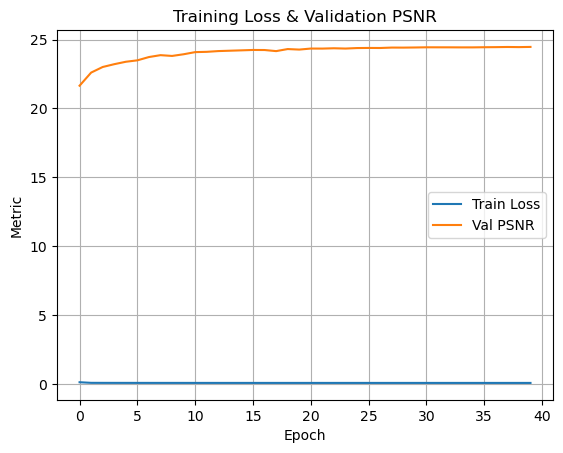

In [59]:
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_psnr"], label="Val PSNR")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Loss & Validation PSNR")
plt.legend()
plt.grid()
plt.show()


In [60]:
model = SRCNN(upscale_factor=4).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()


C:\Users\Aren\AppData\Local\Temp\ipykernel_23340\2579517272.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locati

SRCNN(
  (upscale): Upsample(scale_factor=4.0, mode='bicubic')
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [61]:
val_batch = next(iter(val_loader))
lr_imgs, hr_imgs = val_batch
lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)


In [62]:
with torch.no_grad():
    sr_imgs = model(lr_imgs)


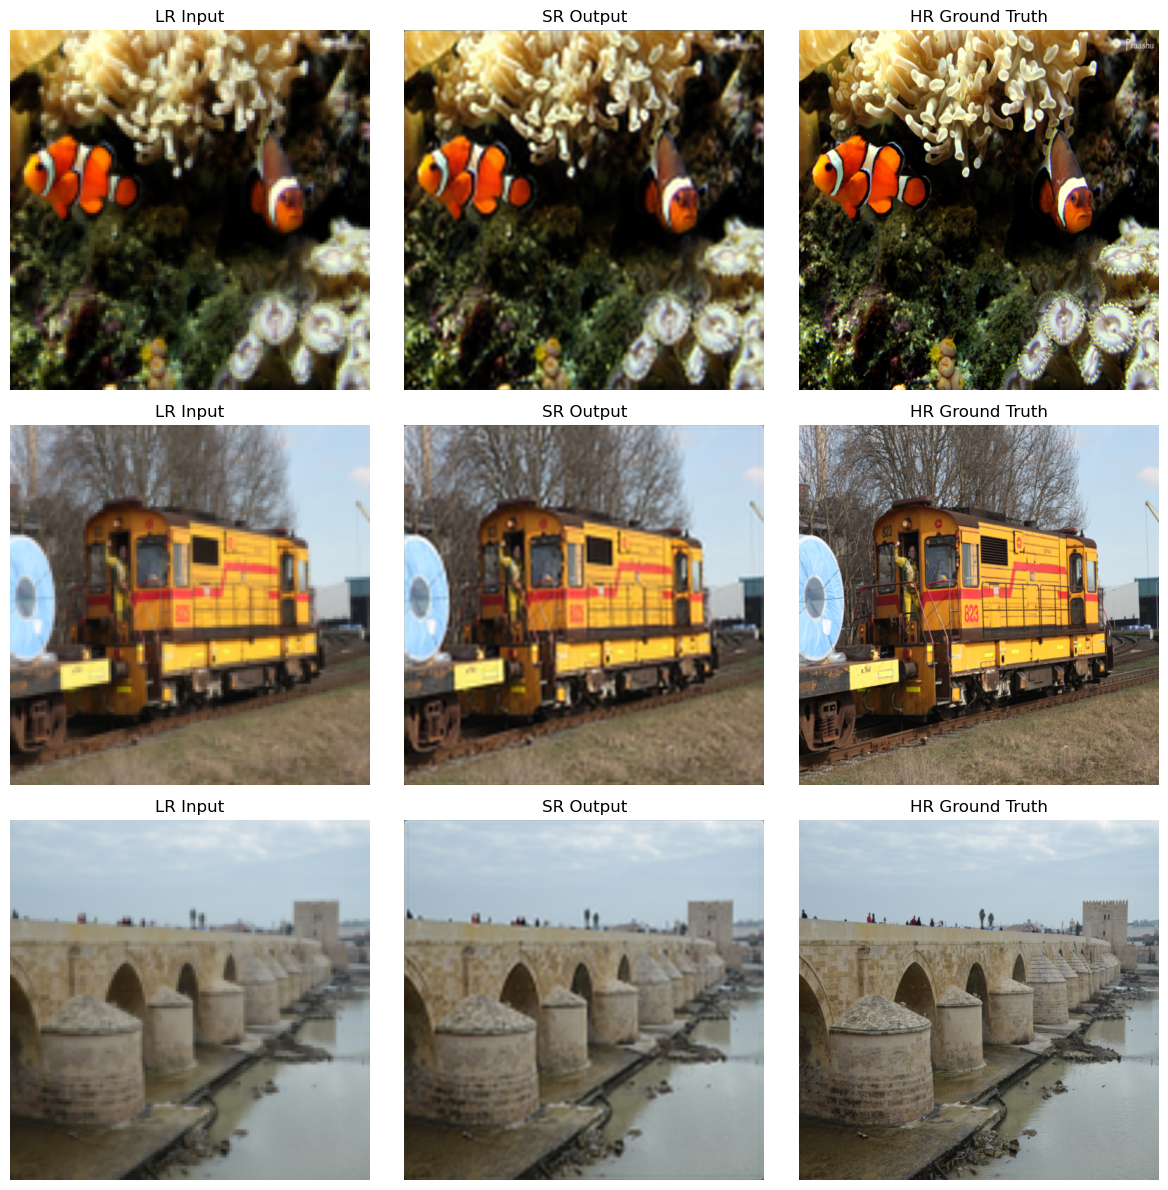

In [95]:
import matplotlib.pyplot as plt

def show_results(lr, sr, hr, n=3):
    fig, axs = plt.subplots(n, 3, figsize=(12, 4 * n))
    for i in range(n):
        axs[i, 0].imshow(lr[i].cpu().permute(1, 2, 0).clamp(0,1))
        axs[i, 0].set_title("LR Input")
        axs[i, 1].imshow(sr[i].cpu().permute(1, 2, 0).clamp(0,1))
        axs[i, 1].set_title("SR Output")
        axs[i, 2].imshow(hr[i].cpu().permute(1, 2, 0).clamp(0,1))
        axs[i, 2].set_title("HR Ground Truth")
        for j in range(3):
            axs[i, j].axis("off")
    plt.tight_layout()
    plt.show()

show_results(lr_imgs, sr_imgs, hr_imgs, n=3)


In [97]:
def calculate_psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    if mse == 0:
        return 100
    return 10 * torch.log10(1 / mse)

for i in range(3):
    psnr = calculate_psnr(sr_imgs[i], hr_imgs[i])
    print(f"Image {i+1} PSNR: {psnr:.2f} dB")


Image 1 PSNR: 24.80 dB
Image 2 PSNR: 24.26 dB
Image 3 PSNR: 30.26 dB


🎯 HR → HR (sanity):     PSNR = 80.00 dB, SSIM = 1.000
🧪 Simulated LR → HR:    PSNR = 26.16 dB, SSIM = 0.719
🏁 SRCNN Output → HR:    PSNR = 28.00 dB, SSIM = 0.860


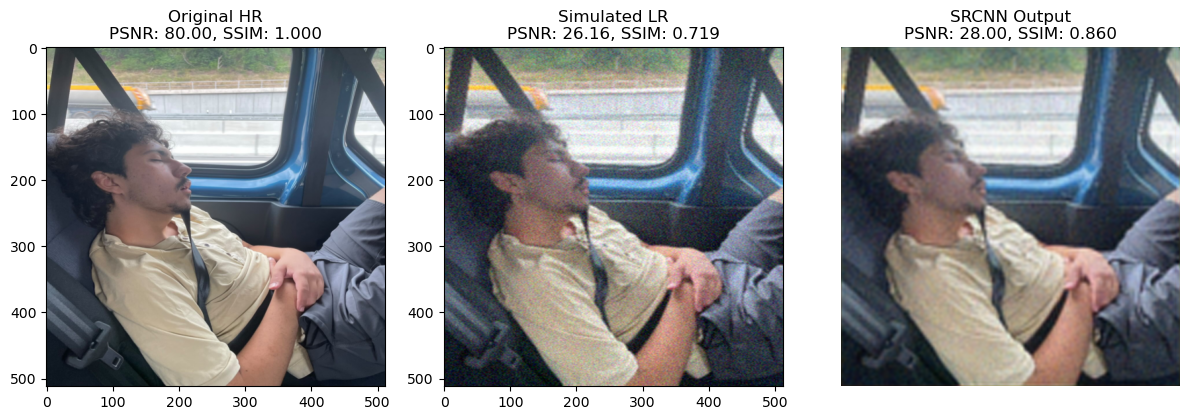

In [179]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from piq import psnr, ssim  # pip install piq

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load your HR image ===
img_path = "Sebastian.jpg"
hr_pil = Image.open(img_path).convert("RGB")

# === Simulate realistic degradation on HR ===
def simulate_lr(img, scale=4):
    img_np = np.array(img)
    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    h, w = img_cv.shape[:2]
    if h < 256 or w < 256:
        # Don't degrade — just upscale to match for consistency
        lr_up = cv2.resize(img_cv, (w, h), interpolation=cv2.INTER_CUBIC)
    else:
        # Degrade as usual
        lr = cv2.resize(img_cv, (w // scale, h // scale), interpolation=cv2.INTER_CUBIC)
        lr = cv2.GaussianBlur(lr, (3, 3), sigmaX=1.0)
        noise = np.random.normal(0, 15, lr.shape).astype(np.float32)
        lr = np.clip(lr.astype(np.float32) + noise, 0, 255).astype(np.uint8)
        lr_up = cv2.resize(lr, (w, h), interpolation=cv2.INTER_CUBIC)

    lr_up_rgb = cv2.cvtColor(lr_up, cv2.COLOR_BGR2RGB)
    return Image.fromarray(lr_up_rgb)


lr_pil = simulate_lr(hr_pil)

# === Define model input/output size ===
model_input_size = 128  # SRCNN input
model_output_size = model_input_size * 4  # SRCNN output

# === Define transforms ===
input_transform = transforms.Compose([
    transforms.Resize((model_input_size, model_input_size)),
    transforms.ToTensor()
])
hr_transform = transforms.Compose([
    transforms.Resize((model_output_size, model_output_size)),
    transforms.ToTensor()
])

# === Transform all tensors ===
lr_tensor = input_transform(lr_pil).unsqueeze(0).to(device)
hr_tensor = hr_transform(hr_pil).unsqueeze(0).to(device)
lr_upscaled_tensor = hr_transform(lr_pil).unsqueeze(0).to(device)

# === Load trained model (assumes already loaded SRCNN model) ===
model.eval()
with torch.no_grad():
    sr_tensor = model(lr_tensor).clamp(0, 1)

# === Compute metrics ===
psnr_hr = psnr(hr_tensor, hr_tensor, data_range=1.0).item()
ssim_hr = ssim(hr_tensor, hr_tensor, data_range=1.0).item()
psnr_lr = psnr(lr_upscaled_tensor, hr_tensor, data_range=1.0).item()
ssim_lr = ssim(lr_upscaled_tensor, hr_tensor, data_range=1.0).item()
psnr_sr = psnr(sr_tensor, hr_tensor, data_range=1.0).item()
ssim_sr = ssim(sr_tensor, hr_tensor, data_range=1.0).item()

# === Print results ===
print(f"🎯 HR → HR (sanity):     PSNR = {psnr_hr:.2f} dB, SSIM = {ssim_hr:.3f}")
print(f"🧪 Simulated LR → HR:    PSNR = {psnr_lr:.2f} dB, SSIM = {ssim_lr:.3f}")
print(f"🏁 SRCNN Output → HR:    PSNR = {psnr_sr:.2f} dB, SSIM = {ssim_sr:.3f}")

# === Visualize all ===
plt.figure(figsize=(12, 4))
to_img = lambda x: x.squeeze().cpu().permute(1, 2, 0).clamp(0, 1)

plt.subplot(1, 3, 1)
plt.imshow(to_img(hr_tensor))
plt.title(f"Original HR\nPSNR: {psnr_hr:.2f}, SSIM: {ssim_hr:.3f}")

plt.subplot(1, 3, 2)
plt.imshow(to_img(lr_upscaled_tensor))
plt.title(f"Simulated LR\nPSNR: {psnr_lr:.2f}, SSIM: {ssim_lr:.3f}")

plt.subplot(1, 3, 3)
plt.imshow(to_img(sr_tensor))
plt.title(f"SRCNN Output\nPSNR: {psnr_sr:.2f}, SSIM: {ssim_sr:.3f}")

for i in range(3): plt.axis('off')
plt.tight_layout()
plt.show()


📊 Against Original Image:
   Bicubic Upscaled → HR:   PSNR = 80.00 dB, SSIM = 1.000
   SRCNN Output     → HR:   PSNR = 37.05 dB, SSIM = 0.982


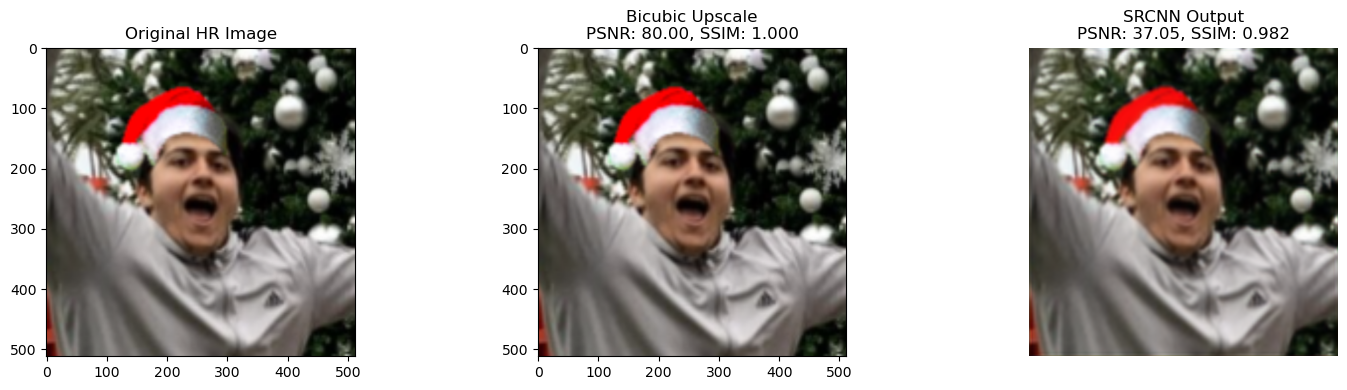

In [181]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from piq import psnr, ssim

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load and resize your image ===
img_path = "sevsanta.jpg"
original_pil = Image.open(img_path).convert("RGB")
resize_to_output = transforms.Resize((512, 512))  # Ensure all images match output size

# Resize HR for fair visual and metric comparison
hr_pil = resize_to_output(original_pil)
lr_pil = hr_pil.copy()  # Treated as the LR input

# === Define transforms ===
input_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
hr_transform = transforms.ToTensor()  # Already resized PIL

# === Prepare tensors ===
lr_tensor = input_transform(lr_pil).unsqueeze(0).to(device)
lr_upscaled_tensor = hr_transform(resize_to_output(lr_pil)).unsqueeze(0).to(device)
hr_tensor = hr_transform(hr_pil).unsqueeze(0).to(device)

# === Run model ===
model.eval()
with torch.no_grad():
    sr_tensor = model(lr_tensor).clamp(0, 1)

# === Compute metrics ===
psnr_bicubic = psnr(lr_upscaled_tensor, hr_tensor, data_range=1.0).item()
ssim_bicubic = ssim(lr_upscaled_tensor, hr_tensor, data_range=1.0).item()
psnr_srcnn = psnr(sr_tensor, hr_tensor, data_range=1.0).item()
ssim_srcnn = ssim(sr_tensor, hr_tensor, data_range=1.0).item()

# === Print results ===
print("📊 Against Original Image:")
print(f"   Bicubic Upscaled → HR:   PSNR = {psnr_bicubic:.2f} dB, SSIM = {ssim_bicubic:.3f}")
print(f"   SRCNN Output     → HR:   PSNR = {psnr_srcnn:.2f} dB, SSIM = {ssim_srcnn:.3f}")

# === Visualize ===
to_img = lambda x: x.squeeze().cpu().permute(1, 2, 0).clamp(0, 1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(hr_pil)
plt.title("Original HR Image")

plt.subplot(1, 3, 2)
plt.imshow(to_img(lr_upscaled_tensor))
plt.title(f"Bicubic Upscale\nPSNR: {psnr_bicubic:.2f}, SSIM: {ssim_bicubic:.3f}")

plt.subplot(1, 3, 3)
plt.imshow(to_img(sr_tensor))
plt.title(f"SRCNN Output\nPSNR: {psnr_srcnn:.2f}, SSIM: {ssim_srcnn:.3f}")

for i in range(3): plt.axis('off')
plt.tight_layout()
plt.show()
